In [1]:
%load_ext autoreload
%autoreload 
import Param_fun as pf
import Metrics_fun as mf
import Bayes_fun as bf
import utils as util
import numpy as np
import matplotlib.pyplot as plt
from GUI import *
import Save_utils as su

In [2]:
#Can supply paths to files directly, but reccomended to use the paths_fromKS function below
#get default parameters, can add your own before or after!
param = util.get_default_param()


# Load in the data

#The channel position i.e location of active channels is assumed to be the same for all recording sessions
ChannelPos1 = np.load(r'Data\Mouse1\AL032\2019-11-21\Probe0\1\channel_positions.npy')
#This makes position 3-D by inserting an axis of all one's in the first axis, to allow easy extension to 3-D coords
ChannelPos1 = np.insert(ChannelPos1,0, np.ones(ChannelPos1.shape[0]), axis =1)

#path to the average waveforms for each session
WavePath1 = r'Data\Mouse1\AL032\2019-11-21\Probe0\1\RawWaveforms'
WavePath2 = r'Data\Mouse1\AL032\2019-11-22\Probe0\1\RawWaveforms'

#path to a tsv file, where the second column contains 'good' for all units you want to include
UnitLabelPath1 = r'Data\Mouse1\AL032\2019-11-21\Probe0\1\cluster_group.tsv'
UnitLabelPath2 = r'Data\Mouse1\AL032\2019-11-22\Probe0\1\cluster_group.tsv'

# need to put paths as a list
WavePaths = [WavePath1 , WavePath2]
UnitLabelPaths = [UnitLabelPath1, UnitLabelPath2]
ChannelPos = [ChannelPos1, ChannelPos1] # Want it per session, however usually will be the same 

In [2]:
#get default parameters, can add your own before or after!
param = util.get_default_param()

#Give the paths to the KS directories for each session
KSdirs = [r'path/to/KSdir/Session1', r'Path/to/KSdir/Session2']
WavePaths, UnitLabelPaths, ChannelPos = util.paths_fromKS(KSdirs)

In [3]:
#read in data and select the good units and exact metadata

GoodUnits = util.get_good_units(UnitLabelPaths ) # goood = False to load in ALL units
waveform, SessionID, SessionSwitch, WithinSession, param = util.load_good_units(GoodUnits, WavePaths, param)
#waveform, SessionID, SessionSwitch, WithinSession, GoodUnits, param = util.load_good_waveforms(WavePaths, UnitLabelPaths, param) # 1-step version of above

# create clusInfo, contains all unit id/session related info
ClusInfo = {'GoodUnits' : GoodUnits, 'SessionSwitch' : SessionSwitch, 'SessionID' : SessionID, 
            'OriginalID' : np.concatenate(GoodUnits) }

In [4]:
#Get parameters from the wavefunction

waveform = pf.detrend_waveform(waveform)

MaxSite, goodidx, goodpos, MaxSiteMean = pf.get_max_sites(waveform, ChannelPos,ClusInfo, param)

SpatialDecayFit , SpatialDecay,  d_10, AvgCentroid, AvgWaveform, PeakTime = pf.decay_and_average_Waveform(waveform,ChannelPos, goodidx, MaxSite, MaxSiteMean, ClusInfo, param)

Amplitude, waveform, AvgWaveform = pf.get_amplitude_shift_Waveform(waveform,AvgWaveform, PeakTime, param)

WaveformDuration, AvgWaveformPerTP, WaveIdx = pf.avg_Waveform_PerTP(waveform,ChannelPos, d_10, MaxSiteMean, Amplitude, AvgWaveform, ClusInfo, param)


In [5]:
#get Metrics/Scores from the extracted parameters

AmpScore = mf.get_simple_metric(Amplitude)
SpatialDecayScore = mf.get_simple_metric(SpatialDecay)
SpatialDecayFitScore = mf.get_simple_metric(SpatialDecayFit, outlier = True)
WVcorrScore = mf.get_WVcorr(AvgWaveform, param)
WFMSEscore = mf.get_WaveformMSE(AvgWaveform, param)

AvgWaveformPerTPFlip = mf.flip_dim(AvgWaveformPerTP, param)
EuclDist = mf.get_Euclidean_dist(AvgWaveformPerTPFlip,param)

CentroidDist, CentroidVar = mf.Centroid_metrics(EuclDist, param)

EuclDistRC = mf.get_recentered_Euclidean_dist(AvgWaveformPerTPFlip, AvgCentroid, param)

CentroidDistRecentered = mf.recentered_metrics(EuclDistRC)
TrajAngleScore, TrajDistScore = mf.dist_angle(AvgWaveformPerTPFlip, param)

c:\Users\Experiment\Documents\temp\UnitMatch\UMPy\Metrics_fun.py:219: RuntimeWarning: invalid value encountered in divide
  ang = np.abs( x1[dimid1,:,:,:,:] - x2[dimid1,:,:,:,:]) / np.abs(x1[dimid2,:,:,:,:] - x2[dimid2,:,:,:,:])


In [6]:
# Average Euc Dist
EuclDist = np.nanmin(EuclDist[:,param['PeakLoc'] - param['waveidx'] == 0, :,:].squeeze(), axis = 1 )

# TotalScore
IncludeThesePairs = np.argwhere( EuclDist < param['MaxDist']) #array indices of pairs to include

# Make a dictionary of score to include
CentroidOverlordScore = (CentroidDistRecentered + CentroidVar) / 2
WaveformScore = (WVcorrScore + WFMSEscore) / 2
TrajectoryScore = (TrajAngleScore + TrajDistScore) / 2

Scores2Include = {'AmpScore' : AmpScore, 'SpatialDecayScore' : SpatialDecayScore, 'CentroidOverlord' : CentroidOverlordScore,
                  'CentroidDist' : CentroidDist, 'WaveformScore' : WaveformScore, 'TrajectoryScore': TrajectoryScore }

TotalScore, Predictors = mf.get_total_score(Scores2Include, param)

#Initial thresholding

ThrsOpt = mf.get_threshold(TotalScore, WithinSession, EuclDist, param, IsFirstPass = True)

param['nExpectedMatches'] = np.sum( (TotalScore > ThrsOpt).astype(int))
priorMatch = 1 - ( param['nExpectedMatches'] / len(IncludeThesePairs))
CandidatePairs = TotalScore > ThrsOpt


In [7]:
#drift
drifts, AvgCentroid, AvgWaveformPerTP = mf.drift_nSessions(CandidatePairs, SessionSwitch, AvgCentroid, AvgWaveformPerTP, TotalScore, param)

Done drift correction per shank for session pair 1 and 2


In [8]:
# re-do metric extraction with the drift corrected arrays, for effected params

AvgWaveformPerTPFlip = mf.flip_dim(AvgWaveformPerTP, param)
EuclDist = mf.get_Euclidean_dist(AvgWaveformPerTPFlip,param)

CentroidDist, CentroidVar = mf.Centroid_metrics(EuclDist, param)

EuclDistRC = mf.get_recentered_Euclidean_dist(AvgWaveformPerTPFlip, AvgCentroid, param)

CentroidDistRecentered = mf.recentered_metrics(EuclDistRC)
TrajAngleScore, TrajDistScore = mf.dist_angle(AvgWaveformPerTPFlip, param)

# Average Euc Dist
EuclDist = np.nanmin(EuclDist[:,param['PeakLoc'] - param['waveidx'] == 0, :,:].squeeze(), axis = 1 )

# TotalScore
IncludeThesePairs = np.argwhere( EuclDist < param['MaxDist']) #array indices of pairs to include, in ML its IncludeThesePairs[:,1]
IncludeThesePairs_idx = np.zeros_like(TotalScore)
IncludeThesePairs_idx[EuclDist < param['MaxDist']] = 1 

# Make a dictionary of score to include
CentroidOverlordScore = (CentroidDistRecentered + CentroidVar) / 2
WaveformScore = (WVcorrScore + WFMSEscore) / 2
TrajectoryScore = (TrajAngleScore + TrajDistScore) / 2

Scores2Include = {'AmpScore' : AmpScore, 'SpatialDecayScore' : SpatialDecayScore, 'CentroidOverlord' : CentroidOverlordScore,
                  'CentroidDist' : CentroidDist, 'WaveformScore' : WaveformScore, 'TrajectoryScore': TrajectoryScore }

TotalScore, Predictors = mf.get_total_score(Scores2Include, param)
ThrsOpt = mf.get_threshold(TotalScore, WithinSession, EuclDist, param, IsFirstPass = False)


param['nExpectedMatches'] = np.sum( (TotalScore > ThrsOpt).astype(int))
priorMatch = 1 - ( param['nExpectedMatches'] / len(IncludeThesePairs))


In [9]:
# Bayes analysis
ThrsOpt = np.quantile(TotalScore[IncludeThesePairs_idx.astype(bool)], priorMatch)
CandidatePairs = TotalScore > ThrsOpt

priorMatch = 1 - (param['nExpectedMatches'] / param['nUnits']**2 )
Priors = np.array((priorMatch, 1-priorMatch))

labels = CandidatePairs.astype(int)
Cond = np.unique(labels)
ScoreVector = param['ScoreVector']
ParameterKernels = np.full((len(ScoreVector), len(Scores2Include), len(Cond)), np.nan)


In [10]:

ParameterKernels = bf.get_ParameterKernels(Scores2Include, labels, Cond, param, addone = 1)

Probability = bf.apply_naive_bayes(ParameterKernels, Priors, Predictors, param, Cond)

Output = Probability[:,1].reshape(param['nUnits'],param['nUnits'])

#can get match only between out of session ones..

In [12]:
#util.compare_units(WeightedAvgWaveform, AvgCentroid, 7,466 )

In [11]:
util.evaluate_output(Output, param, WithinSession, SessionSwitch, MatchThreshold = 0.75)

The percentage of units matched to themselves is: 95.43795620437956%
The percentage of false -ve's then is: 4.56204379562044% 

The rate of miss-match(es) per expected match 0.07846715328467153
The percentage of false +ve's is 0.025972002181648184% for session 1
The percentage of false +ve's is 0.03166735508742944% for session 2

This assumes that the spike sorter has made no mistakes


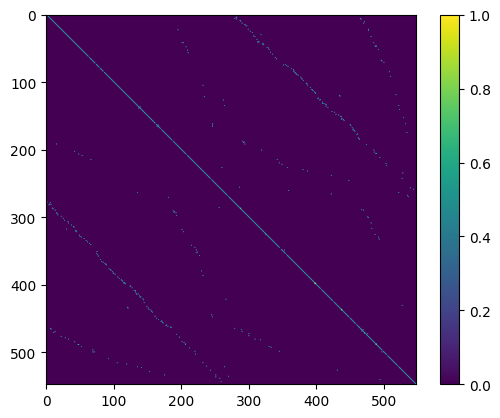

In [12]:
MatchThreshold = 0.5
OutputThreshold = np.zeros_like(Output)
OutputThreshold[Output > MatchThreshold] = 1

plt.imshow(OutputThreshold)
#plt.imshow(Output)
plt.colorbar()

In [13]:
matches = np.argwhere( ((OutputThreshold * WithinSession)) == True)
matches[:10]

array([[  1, 278],
       [  4, 282],
       [  5, 281],
       [  6, 279],
       [  6, 465],
       [  7, 282],
       [  7, 466],
       [  9, 287],
       [ 10, 288],
       [ 11, 471]], dtype=int64)

In [32]:
process_info_for_GUI(Output, MatchThreshold, Scores2Include, TotalScore, Amplitude, SpatialDecay,
                         AvgCentroid, AvgWaveform, AvgWaveformPerTP, WaveIdx, MaxSite, MaxSiteMean, 
                         waveform, WithinSession, ChannelPos, ClusInfo, param)

In [34]:
IsMatch, NotMatch = run_GUI()

In [19]:
Matches = np.argwhere(OutputThreshold == 1)
MatchesCurrated = util.currate_matches(MatchesGUI, IsMatch, NotMatch, Mode = 'And')

In [18]:
SaveDir = r'Path\to\Save\directory'

In [20]:
#save base output
#su.save_to_output(SaveDir, Scores2Include, Matches, Output, AvgCentroid, AvgWaveform, AvgWaveformPerTP, MaxSite, TotalScore, OutputThreshold, ClusInfo, param, MatchesCurated = None, SaveMatchTable = True)
#save seperate CV output
su.save_to_output_seperate_CV(SaveDir, Scores2Include, Matches, Output, AvgCentroid, AvgWaveform, AvgWaveformPerTP, MaxSite,
                   TotalScore, MatchThreshold, ClusInfo, param, MatchesCurated = None, SaveMatchTable = True)
